# HBR transfer example

Welcome to this example/tutorial notebook that will go through the fitting, evaluation, and transfering of HBR models. 

### Imports

In [1]:
# Need to install graphviz for the graphical model visualization
# %conda install -c conda-forge python-graphviz graphviz

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param import Param
from pcntoolkit.regression_model.hbr.hbr import HBR
from pcntoolkit.util.plotter import plot_centiles, plot_qq
import seaborn as sns
import arviz as az

# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [3]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)

In [4]:
data = pd.read_csv("resources/data/fcon1000.csv")

Plot the distribution of sex and site in the data.

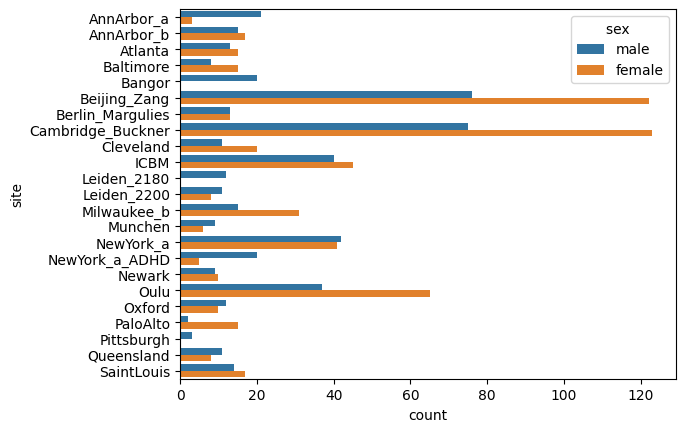

In [5]:
data["sex "] = np.where(data["sex"] == 1, ["male"], ["female"])
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()

Our HBR models will use random effects to model differences between sites. Because the random effects are best captured when there are enough samples of each effect in the data, we will have to remove some sites that are too small. We will filter out sites for which any of the sexes is represented by less than 10 samples

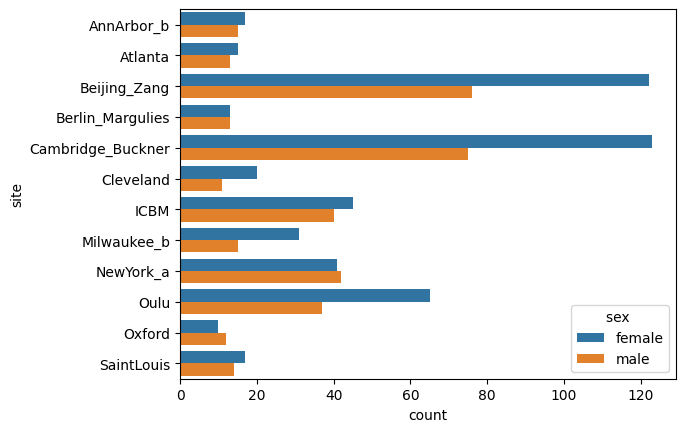

In [6]:
site_counts = data.groupby(["site", "sex"]).size().reset_index(name="counts")  # type: ignore
sex_count_per_site = site_counts["site"].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site == 1]
sites_with_one_sex.index
data = data[~data["site"].isin(sites_with_one_sex.index)]
site_counts = site_counts[site_counts["counts"] < 10]
data = data[~data["site"].isin(site_counts["site"])]
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()


Now we load the data into a `NormData` object. 

In [7]:
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

We will use 2 sites for transfer (Milwaukee and Oulu) and the rest for training.

In [8]:
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects(
    {"site": transfer_sites}, names=["transfer", "fit"]
)


We also split the data into train and test sets.

In [9]:
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. Our `NormConf` configuration contains canonical paths, a standardization step for both the input as as the output data, and a Bspline basis expansion.

In [10]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/hbr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

Configuration of normative model is valid.


## Configure the regression model

HBR models need to specificy (possibly recursive) parameter configurations. Here, we configure a HBR model with a SHASHb likelihood, a bspline regression in `mu` and `sigma`, and a random effect in the intercept of `mu`. Note that because sigma has to be strictly positive, we specify a `softplus` mapping, so that the output of the linear regression is mapped to the positive domain. 

In [13]:
mu = Param(
    name="mu",
    linear=True,
    slope=Param(dist_name="Normal", dist_params=(0.0, 10.0)),
    intercept=Param(
        random=True,
        centered=False,
        mu=Param(dist_name="Normal", dist_params=(0.0, 1.0)),
        sigma=Param(dist_name="HalfCauchy", dist_params=(1.0,)),
    ),
)
sigma = Param(
    name="sigma",
    linear=True,
    slope=Param(dist_params=(0.0, 5.0)),
    intercept=Param(dist_name="Normal", dist_params=(1.0, 2.0)),
    mapping="softplus",
    mapping_params=(0.0, 5.0),
)
epsilon = Param(
    name="epsilon",
    linear=False,
    dist_name="Normal",
    dist_params=(0, 10.0),
)
delta = Param(
    name="delta",
    linear=False,
    dist_name="Normal",
    dist_params=(0.0, 3.0),
    mapping="softplus",
    mapping_params=(0.0, 5.0, 0.3),
)
import pprint

pprint.pprint(mu.to_dict())
# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=1500,
    tune=500,
    chains=4,
    pymc_cores=16,
    likelihood="SHASHo",
    mu=mu,
    sigma=sigma,
    epsilon=epsilon,
    delta=delta,
    nuts_sampler="nutpie",
    init="jitter+adapt_diag",
)

{'centered': False,
 'dims': None,
 'has_random_effect': True,
 'intercept': {'centered': False,
               'dims': None,
               'has_random_effect': True,
               'linear': False,
               'mu': {'centered': False,
                      'dims': None,
                      'dist_name': 'Normal',
                      'dist_params': (0.0, 1.0),
                      'has_random_effect': False,
                      'linear': False,
                      'name': 'mu_intercept_mu',
                      'random': False},
               'name': 'intercept_mu',
               'random': True,
               'sigma': {'centered': False,
                         'dims': None,
                         'dist_name': 'HalfCauchy',
                         'dist_params': (1.0,),
                         'has_random_effect': False,
                         'linear': False,
                         'name': 'sigma_intercept_mu',
                         'random': False}},
 'li

## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [38]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [39]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

## Fit the model
With all our configuration done, we can fit our model on the train data. 

In [40]:
predictions = norm_hbr.fit_predict(train, test)

Going to fit and predict 2 models
Fitting and predicting model for rh_MeanThickness_thickness


KeyboardInterrupt: 

As we can see, the model is saved to the save_dir specified in the norm_conf. We can inspect that folder to find three subfolders:
- `model`: contains the model and metadata
- `results`: containing csv files with the evaluation results for all response variables
- `plots`: containing qq plots and centile plots for each response variable

## Inspecting the model 

The norm_hbr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_hbr.regression_models.get("{responsevar}")`

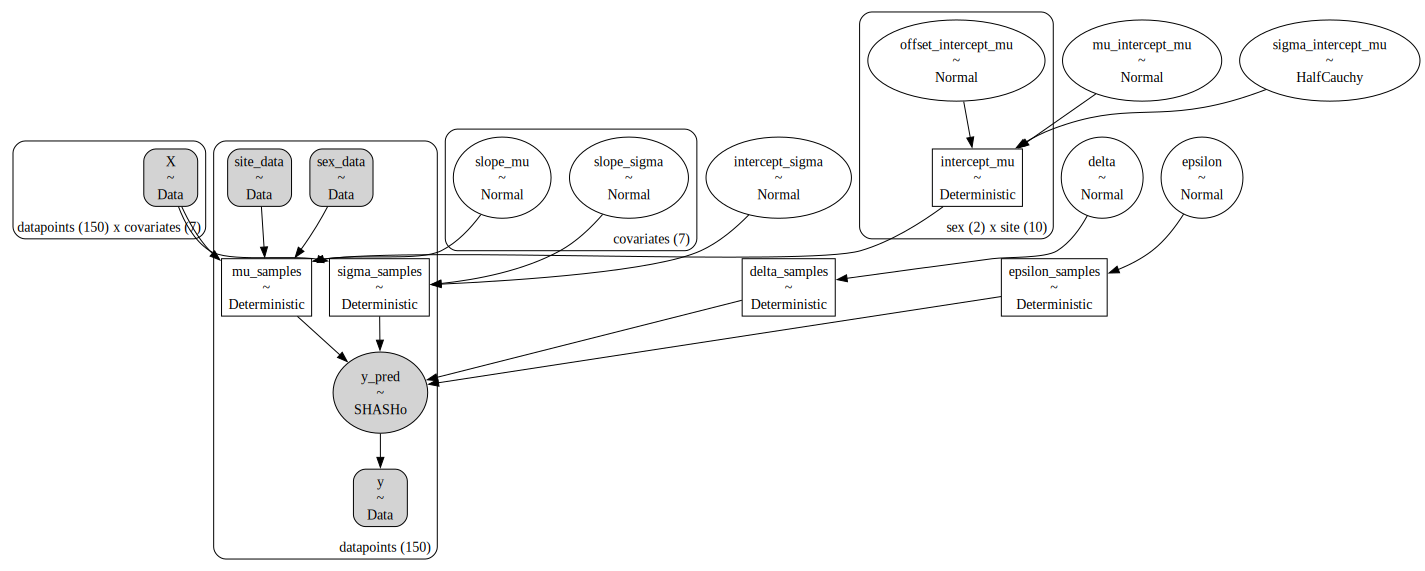

In [14]:
model: HBR = norm_hbr.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
model.pymc_model.to_graphviz()  # type: ignore

We can use the arviz library to inspect the posterior samples (trace) of the model. Here we only use the 'plot_trace' function to inspect the trace of the model, but there are many other useful functions available. If you are not familiar with arviz, we recommend checking out the [arviz documentation](https://arviz-devs.github.io/arviz/index.html).


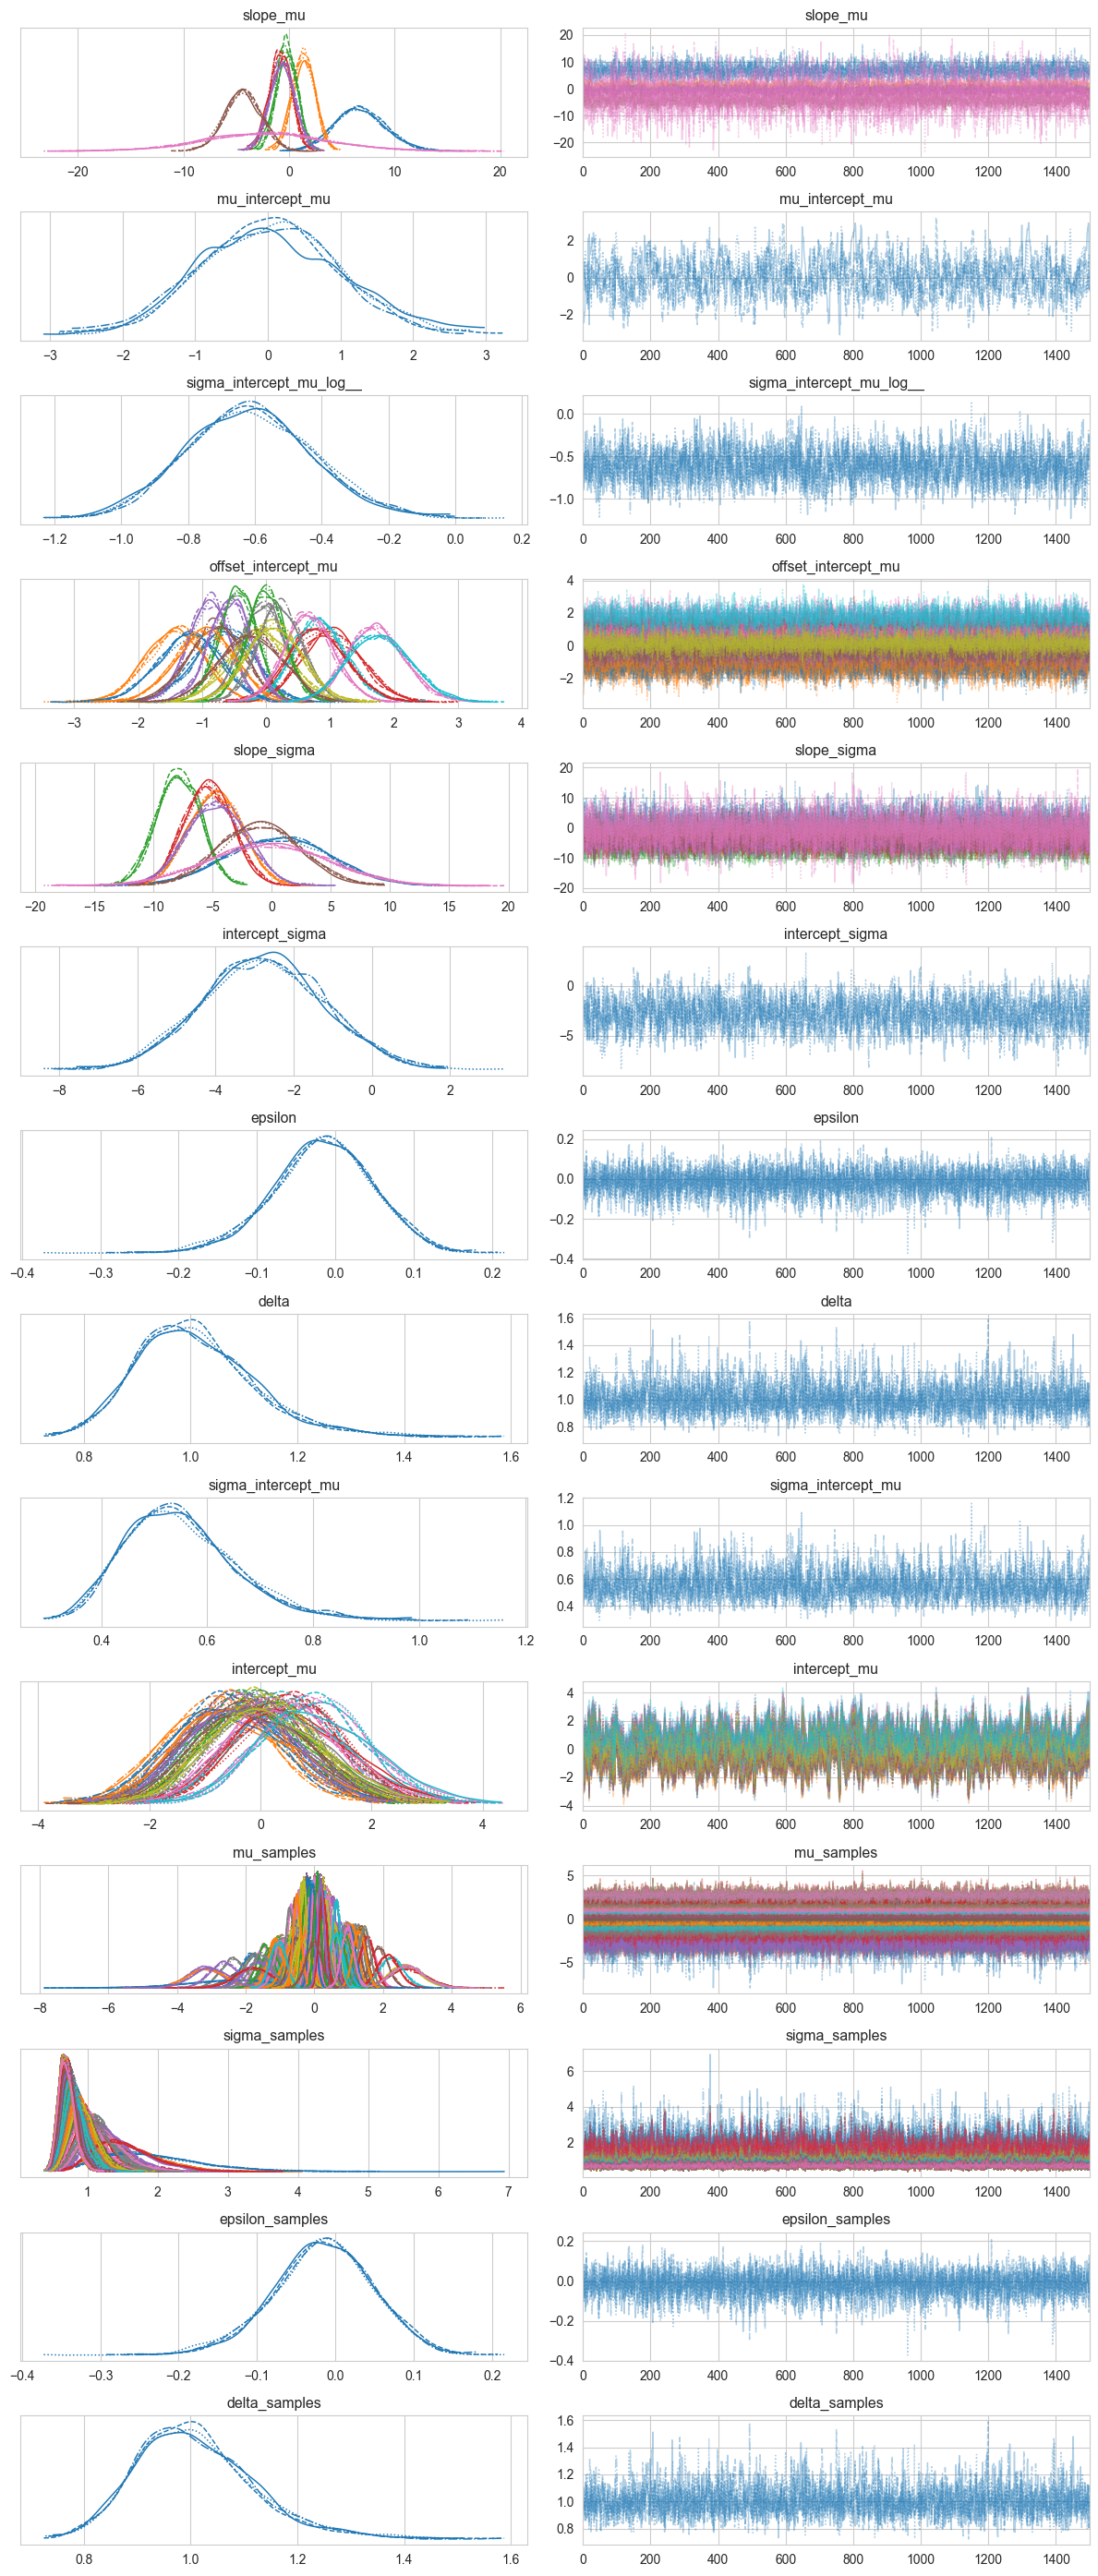

In [15]:
idata = model.idata  # type: ignore

az.plot_trace(idata.posterior)
plt.tight_layout()
plt.show()

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [16]:
display(test.measures.to_pandas().T)


response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.513285,0.499768
RMSE,0.076481,460.933863
SMSE,0.601306,0.651461
ExpV,0.399440,0.357518
NLL,NaN,NaN
ShapiroW,0.992057,0.980620


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [17]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
124,0.680315,1.045520
48,-0.368228,-0.787797
545,0.696908,0.245460
847,1.134059,0.685581
360,-2.236545,-0.038952
...,...,...
688,-1.194561,0.400296
420,0.738329,0.851790
123,-0.965034,-1.327848


In [18]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
124                             2.370990         600.987308   
48                              2.321411         523.187830   
545                             2.287174         752.812639   
847                             2.364265         721.438942   
360                             2.364678         905.348186   
...                                  ...                ...   
688                             2.333629         653.115385   
420                             2.380830         878.891314   
123                             2.404569         691.136646   
276                             2.408735         438.912433   
183                             2.382288         608.756800   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
124                             2.436794         783.954420   
48                              2.387214         706.154942   
545                             2.378737        1254.441785   
847                             2.428601         913.681482   
360                             2.430481        1088.315297   
...                                  ...                ...   
688                             2.400307         856.952300   
420                             2.453536        1066.266168   
123                             2.472344         873.522645   
276                             2.472792         627.729043   
183                             2.450063         791.142799   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
124                             2.482134         937.764421   
48                              2.432554         859.964943   
545                             2.441885        1675.997460   
847                             2.472919        1075.312669   
360                             2.475822        1242.125299   
...                                  ...                ...   
688                             2.446242        1028.330893   
420                             2.503647        1223.746129   
123                             2.519049        1026.831548   
276                             2.516920         786.476538   
183                             2.496769         944.451703   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
124                             2.527098        1188.681027   
48                              2.477519        1110.881549   
545                             2.504530        2363.063085   
847                             2.516869        1338.892455   
360                             2.520786        1493.041904   
...                                  ...                ...   
688                             2.491792        1307.743901   
420                             2.553337        1480.716763   
123                             2.565366        1276.956942   
276                             2.560682        1045.380148   
183                             2.543085        1194.577097   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


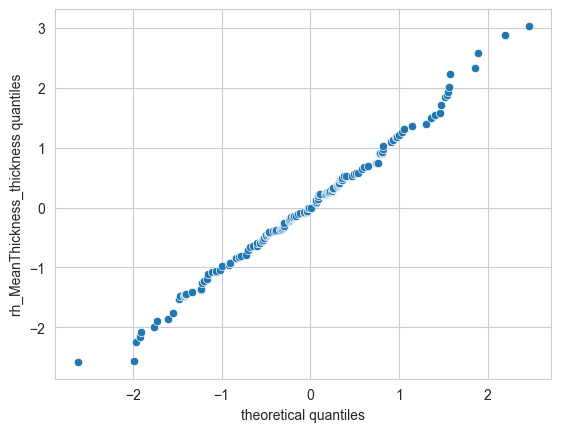

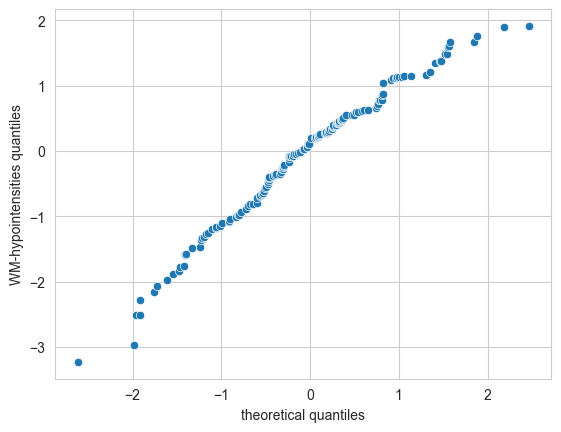

In [19]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


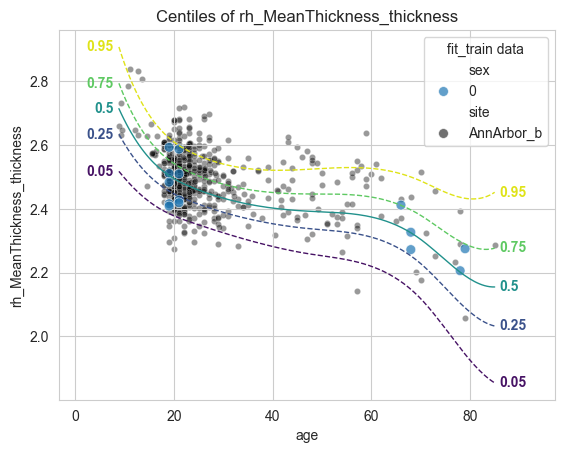

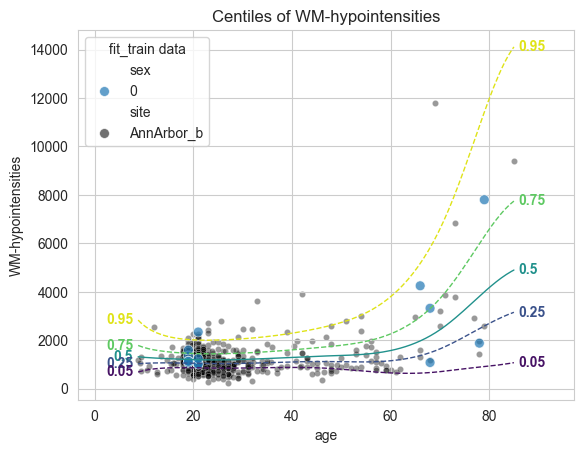

In [20]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


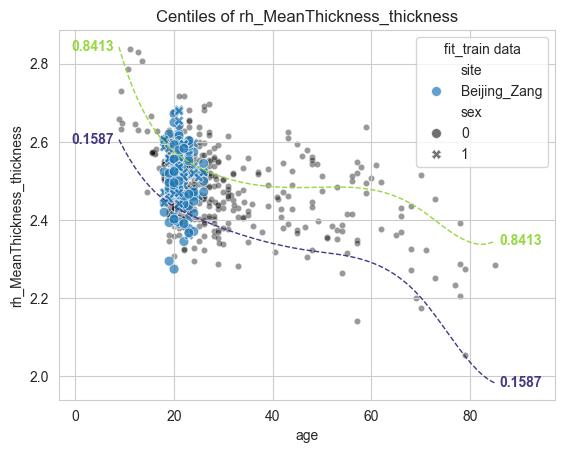

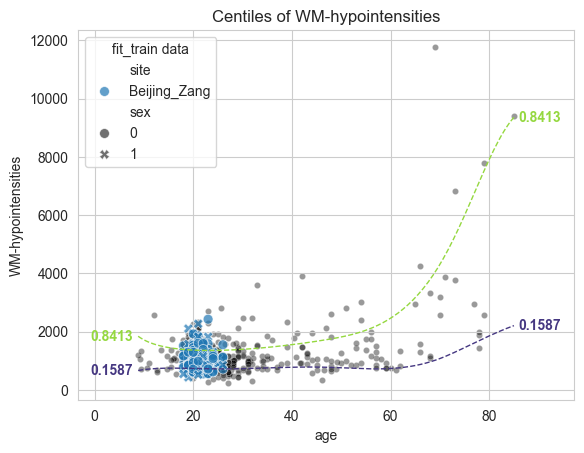

In [23]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Beijing_Zang"]},
)

## Transfer

We transfer the model to the transfer_train dataset that we created before. The posterior distribution is factorized and a new RegConf is created using the factorized posterior as a prior. To give some extra control, we let the `freedom` parameter control the variance of the derived factorized posterior. With a `freedom` of 1, the factorized representation is used as is. With freedom of `2`, all derived prior distributions are widened by a factor of 2. 

In [25]:
transfered_model = norm_hbr.transfer(transfer_train, freedom=2, nuts_sampler="nutpie")
# Caused by:
#     Logp function returned error: Logp function returned error code 4

Going to transfer 2 models
Transferring model for rh_MeanThickness_thickness


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.15,127
,2000,0,0.15,63
,2000,0,0.14,63
,2000,0,0.15,63


Transferring model for WM-hypointensities


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.11,191
,2000,0,0.11,223
,2000,0,0.11,127
,2000,0,0.11,127


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/normative_model/norm_conf.py:166: UserWarning: save_dir (resources/save_dir_transfer) does not exist, creating it for you
  warnings.warn(


Configuration of normative model is valid.
52382 Saving model to resources/save_dir_transfer
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/save_dir_transfer/model


We can save, load, predict, and plot just as before. 

If the orinal save directory path was `{path}/{save_dir}`, then the transfered model's save directory path will be `{path}/{save_dir}_tansfer`, and the same holds for the log dir path

In [26]:
transfered_model.save()

52382 Saving model to resources/save_dir_transfer
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/save_dir_transfer/model


In [28]:
transfered_model = load_normative_model("resources/save_dir_transfer")
transfered_predictions = transfered_model.predict(transfer_test)

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Output()

Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing zscores for WM-hypointensities


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/save_dir_transfer/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/save_dir_transfer/plots


In [31]:
display(transfered_predictions.measures.to_pandas().T)
display(transfered_predictions.zscores.to_pandas())
display(
    transfered_predictions.centiles.to_dataframe().unstack(
        level=["response_vars", "cdf"]
    )
)

response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.121717,0.429049
RMSE,0.097872,416.851614
SMSE,1.267294,0.833959
ExpV,-0.225293,0.353732
NLL,NaN,NaN
ShapiroW,0.885744,0.976467


response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
794,-0.969700,-0.108986
796,0.058182,0.019022
758,-0.239453,0.777495
786,2.330631,-0.554833
746,-1.731670,-0.763365
749,-0.087545,-0.246852
802,-1.455284,-0.932355
812,0.271862,-0.425021
730,-1.022334,-0.116732


centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
794                             2.401870         -47.270030   
796                             2.419151          60.642683   
758                             2.428774         260.560465   
786                             2.377249        -155.414613   
746                             2.411493         152.647753   
749                             2.419151          60.642683   
802                             2.419151          60.642683   
812                             2.419151          60.642683   
730                             2.428774         260.560465   
640                             2.318149         461.653542   
607                             2.291533         322.379727   
731                             2.419151          60.642683   
641                             2.375169       -1124.367898   
750                             2.419151          60.642683   
638                             2.382022        -323.127229   
619                             2.292328         448.027456   
826                             2.401870         -47.270030   
808                             2.401870         -47.270030   
740                             2.411493         152.647753   
626                             2.407010        -874.871528   
807                             2.401870         -47.270030   
800                             2.411493         152.647753   
608                             2.393222       -1118.603886   
613                             2.306596         395.386619   
774                             2.419151          60.642683   
599                             2.300666         520.945338   
747                             2.411493         152.647753   
816                             2.428774         260.560465   
751                             2.411493         152.647753   
819                             2.401870         -47.270030   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
794                             2.489245         460.956552   
796                             2.497532         490.006169   
758                             2.507155         689.923951   
786                             2.476508         465.030741   
746                             2.498869         660.874335   
749                             2.497532         490.006169   
802                             2.497532         490.006169   
812                             2.497532         490.006169   
730                             2.507155         689.923951   
640                             2.391199         711.743776   
607                             2.340081        1086.500537   
731                             2.497532         490.006169   
641                             2.543018         483.149109   
750                             2.497532         490.006169   
638                             2.446724        1008.084166   
619                             2.353837         810.903547   
826                             2.489245         460.956552   
808                             2.489245         460.956552   
740                             2.498869         660.874335   
626                             2.508892         666.571504   
807                             2.489245         460.956552   
800                             2.498869         660.874335   
608                             2.545485         488.958374   
613                             2.379645         645.476853   
774                             2.497532         490.006169   
599                             2.358573         941.647189   

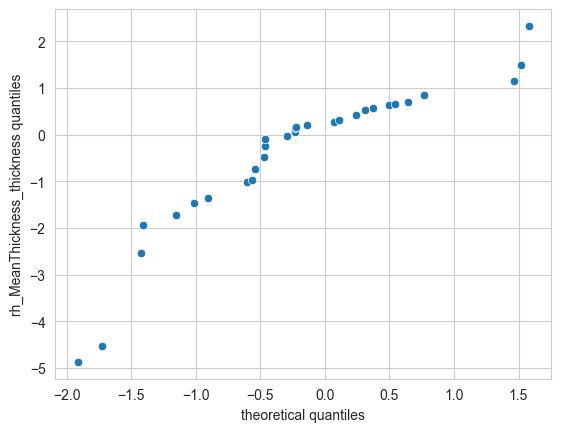

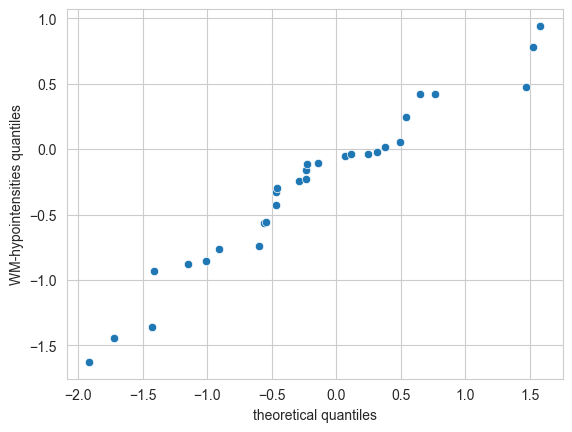

In [33]:
plot_qq(transfer_test)

Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


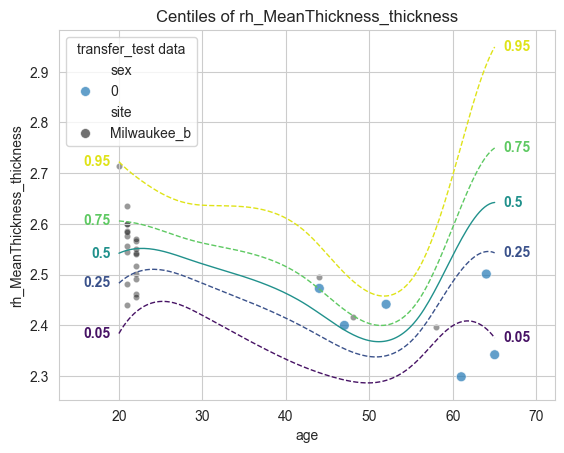

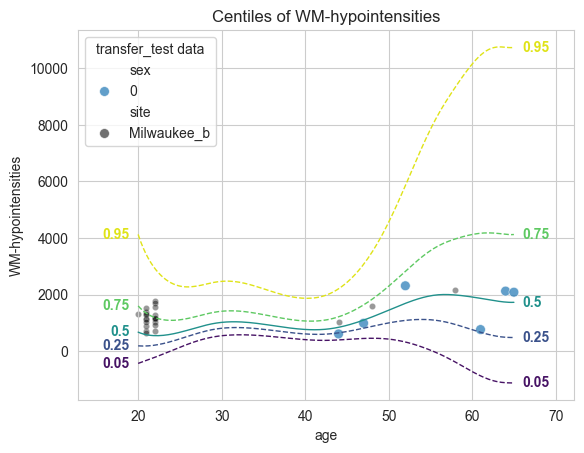

In [35]:
plot_centiles(
    transfered_model,
    transfer_test,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

And that's it, now you have seen how to:
- Use the NormData class to load in your data
- Create and fit a normative model
- Get the evaluation statistics, and create some useful plots
- Transfer the model to another dataset

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!